In [0]:
import os
!rm -rf *
!rm -rf .kaggle/
!git clone https://github.com/bkahn-github/data-science-bowl.git
!pip install -r data-science-bowl/requirements.txt
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install Pillow
!pip install click
!mkdir ~/.kaggle
f = open(".kaggle/kaggle.json", "w")
f.write('{"username":"bkkaggle","key":"bf4e62680116284087ace0484990f87a"}')
f.close()
!kaggle competitions download -c data-science-bowl-2018
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train.zip -d ~/.kaggle/competitions/data-science-bowl-2018/stage1_train
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_test.zip -d ~/.kaggle/competitions/data-science-bowl-2018/stage1_test
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train_labels.csv.zip -d ~/.kaggle/competitions/data-science-bowl-2018/
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_sample_submission.csv.zip -d ~/.kaggle/competitions/data-science-bowl-2018/

In [2]:
import os
os.chdir('data-science-bowl/pytorchMultiOutputUnet/')
!git checkout multioutput-unet

Branch multioutput-unet set up to track remote branch multioutput-unet from origin.
Switched to a new branch 'multioutput-unet'


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1qRwtzTiY72JEv5MKSL58yHyZwayKFRhZ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('model-15.pt')

In [0]:
!python main.py subset --subset=False preprocess

In [0]:
import os
import click
import logging
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from config import config
from create_masks import create_masks
from loaders import TrainDataset, x_transforms, y_transforms
from model import Unet
from metrics import dice_loss
from utils import get_ids

import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
    
config.SUBSET = True  

class DiceLoss(nn.Module):
  def __init__(self):
    super(DiceLoss, self).__init__()
  def forward(self, output, target):
    prediction = output
    return 1 - 2 * torch.sum(prediction * target) / (torch.sum(prediction) + torch.sum(target) + 1e-7)

def segmentation_loss(output, target):
  bce = nn.BCEWithLogitsLoss()
  dice = DiceLoss()
  return bce(output, target) + dice(output, target)

def train(epochs, weights):
    logging.info('Starting Training')
    logging.info('Training for ' + str(epochs) + ' epochs')

    logging.info('Getting Ids')
    ids = get_ids()

    logging.info('Creating Training Dataset')
    train = TrainDataset(ids, x_transform=x_transforms, y_transform=y_transforms)
    trainDataloader = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)

    model = Unet()

    if torch.cuda.is_available():
        model.cuda()

    startingEpoch = 0
    if weights != '':
        startingEpoch = weights.split('-')[-1].split('.')[0]
        logging.info('Starting from epoch ' + startingEpoch)
        model.load_state_dict(torch.load(weights))

    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

    for epoch in range(epochs):
        epoch = epoch + int(startingEpoch) + 1

        logging.info('Epoch # ' + str(epoch))
        for data in tqdm(trainDataloader):
            img, target = data['img'], data['target']

            if torch.cuda.is_available():         
                x = Variable(img).cuda()
                y = Variable(target).cuda()
            else:
                x = Variable(img)
                y = Variable(target)                

            optimizer.zero_grad()

            outs = model(x)

            total_loss = segmentation_loss(outs, y)
            total_loss.backward()

            optimizer.step()
            
        
        print('\nTraining Loss: ' + str(total_loss.data.cpu().numpy()[0]))

        torch.save(model.state_dict(), './model-' + str(epoch) + '.pt')

In [4]:
!python main.py subset --subset=False train --epochs=10

2018-04-22 01-18-13 root >>> Started the program
2018-04-22 01-18-13 root >>> Using the full dataset
2018-04-22 01-18-13 root >>> Starting Training
2018-04-22 01-18-13 root >>> Training for 10 epochs
2018-04-22 01-18-13 root >>> Getting Ids
2018-04-22 01-18-13 root >>> Creating Training Dataset
2018-04-22 01-18-16 root >>> Epoch # 1
100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.33923757
2018-04-22 01-22-54 root >>> Epoch # 2
 29%|████████████                              | 48/168 [01:18<03:16,  1.64s/it]

100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.32380337
2018-04-22 01-27-33 root >>> Epoch # 3
100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.3346792
2018-04-22 01-32-11 root >>> Epoch # 4
 81%|█████████████████████████████████▏       | 136/168 [03:44<00:52,  1.65s/it]

100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.31136382
2018-04-22 01-36-50 root >>> Epoch # 5
100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.32097077
2018-04-22 01-41-28 root >>> Epoch # 6
 92%|█████████████████████████████████████▊   | 155/168 [04:16<00:21,  1.66s/it]

100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.29137534
2018-04-22 01-46-07 root >>> Epoch # 7
100%|█████████████████████████████████████████| 168/168 [04:38<00:00,  1.65s/it]

Training Loss: 0.28632683
2018-04-22 01-50-46 root >>> Epoch # 8
 95%|███████████████████████████████████████  | 160/168 [04:24<00:13,  1.65s/it]

100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.27314126
2018-04-22 01-55-24 root >>> Epoch # 9
100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.2737062
2018-04-22 02-00-02 root >>> Epoch # 10
 96%|███████████████████████████████████████▎ | 161/168 [04:26<00:11,  1.66s/it]

100%|█████████████████████████████████████████| 168/168 [04:37<00:00,  1.65s/it]

Training Loss: 0.26402104


In [0]:
train(5, '')

In [0]:
!ls

In [0]:
import os
import click
import logging
from tqdm import tqdm

import torch
import torchvision

from torch.utils.data import DataLoader

import skimage.morphology
from skimage.filters import threshold_otsu

from config import config
from create_masks import create_masks
from loaders import TrainDataset, x_transforms, y_transforms
from model import Unet
from utils import get_ids, get_path
from metrics import dice_loss

import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

config.SUBSET = False

model2 = Unet()
model2.load_state_dict(torch.load('model-10.pt'))
model2.eval()
model2.cuda()

In [0]:
import matplotlib.pyplot as plt

def visualize():
  
  ids = get_ids()
  
  train = TrainDataset(ids, x_transform=x_transforms, y_transform=y_transforms)
  trainDataloader = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)

  for data in trainDataloader:
    img, target = data['img'], data['target']

    x = Variable(img).cuda()
    y = Variable(target).cuda()

    outs = model2(x)
    break
  
  x = x.data.cpu().numpy()
  masks = outs[:,0].data.cpu().numpy()
  contours = outs[:,1].data.cpu().numpy()
  centers = outs[:,2].data.cpu().numpy()
  
  fig = plt.figure(figsize=(20, 10))
  
  ax = plt.subplot("241")
  ax.set_title(str(x[0].min()) + ' ' + str(x[0].max()))
  ax.imshow(x[0].reshape(256, 256, 3)*0.5+0.5)

  ax = plt.subplot("242")
  ax.set_title(str(masks[0].min()) + ' ' + str(masks[0].max()))
  ax.imshow(masks[0])

  ax = plt.subplot("243")
  ax.set_title(str(masks[0].min()) + ' ' + str(masks[0].max()))
  ax.imshow((masks[0] > 0.5))

  ax = plt.subplot("244")
  lab_img = skimage.morphology.label(masks[0] > 0.5)
  ax.set_title(str(lab_img.min()) + ' ' + str(lab_img.max()))
  ax.imshow(lab_img.reshape(256, 256))
  
  ax = plt.subplot("245")
  ax.set_title(str(contours[0].min()) + ' ' + str(contours[0].max()))
  ax.imshow((contours[0]))

  ax = plt.subplot("246")
  ax.set_title(str(contours[0].min()) + ' ' + str(contours[0].max()))
  ax.imshow((contours[0] > 0.5))

  ax = plt.subplot("247")
  ax.set_title(str(centers[0].min()) + ' ' + str(centers[0].max()))
  ax.imshow((centers[0]))

  ax = plt.subplot("248")
  ax.set_title(str(centers[0].min()) + ' ' + str(centers[0].max()))
  ax.imshow((centers[0] > 0.5))


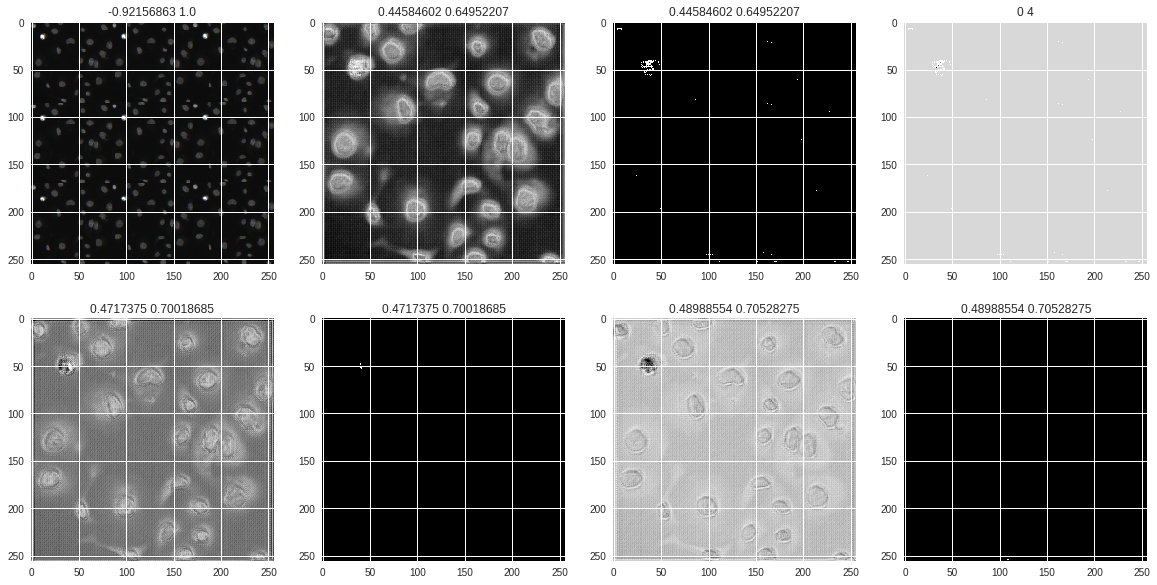

In [7]:
visualize()

In [0]:
ids = get_ids()

train = TrainDataset(ids, x_transform=x_transforms, y_transform=y_transforms)
trainDataloader = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)

for data in trainDataloader:
  img, target = data['img'], data['target']

  x = Variable(img).cuda()
  y = Variable(target).cuda()

  outs = model2(x)
  break

In [0]:
x = x.data.cpu().numpy()
y = y.data.cpu().numpy()
outs = outs.data.cpu().numpy()

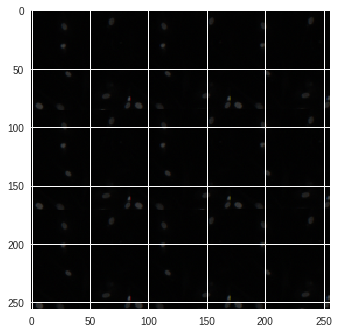

In [194]:
plt.imshow(x[1].reshape(256, 256, 3)*0.5+0.5)
# x[1].max()

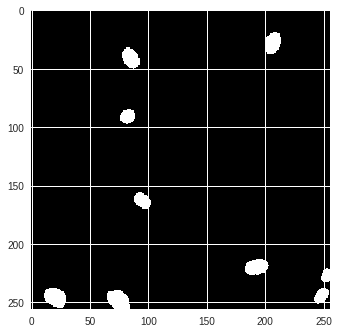

In [195]:
plt.imshow(y[1][0].reshape(256, 256))

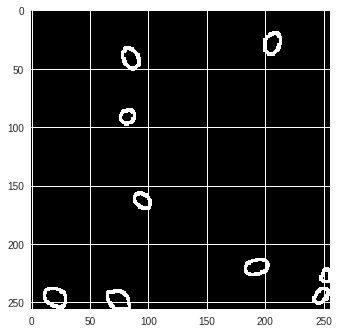

In [196]:
plt.imshow(y[1][1].reshape(256, 256))

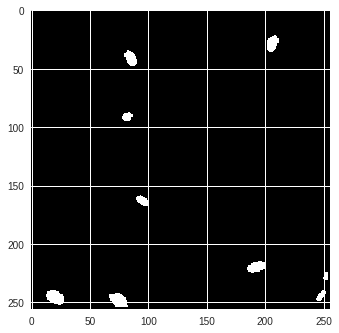

In [197]:
plt.imshow((((y[1][0] - y[1][1])) > threshold_otsu((y[1][0] - y[1][1]))).reshape(256, 256))

0.47376767 0.70381635


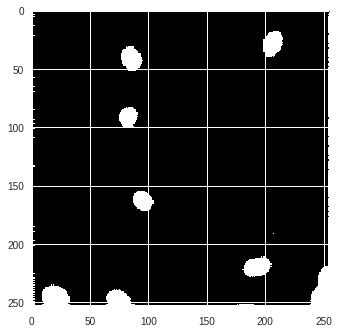

In [198]:
plt.imshow((outs[1][0] > threshold_otsu(outs[1][0])).reshape(256, 256))
print(outs[1][0].min(), outs[1][0].max())

0.53275675 0.7273935


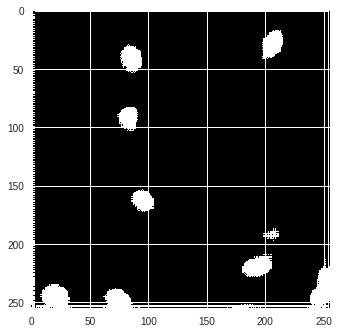

In [199]:
plt.imshow((outs[1][1] > threshold_otsu(outs[1][1])).reshape(256, 256))
print(outs[1][1].min(), outs[1][1].max())

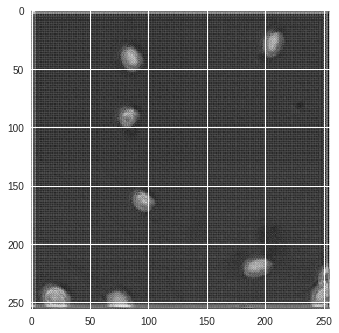

In [200]:
plt.imshow((outs[1][0]) - (outs[1][1]).reshape(256, 256))

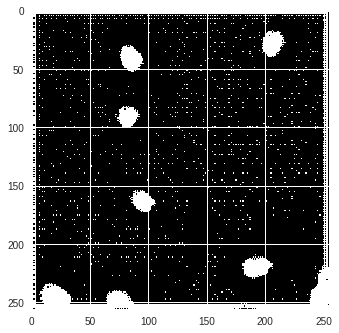

In [201]:
plt.imshow(((outs[1][0] - outs[1][1]) > 0).reshape(256, 256))

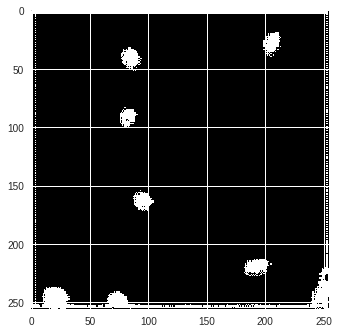

In [202]:
plt.imshow(((outs[1][0] - outs[1][1]) > threshold_otsu((outs[1][0]) - (outs[1][1])) ).reshape(256, 256))

In [0]:
import os
import glob
import numpy as np

import torch
import torchvision

from utils import get_ids, get_path

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform
from PIL import Image

id = get_ids()[0]

img_path, mask_path, contour_path, center_path = get_path(id)

img = Image.open(img_path)
img.load()

RGBimg = Image.new("RGB", img.size, (255, 255, 255))
RGBimg.paste(img, mask=img.split()[3])

img = np.array(RGBimg)

mask = io.imread(mask_path)
contour = io.imread(contour_path)
center = io.imread(center_path)

mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
contour = contour.reshape(contour.shape[0], contour.shape[1], 1)
center = center.reshape(center.shape[0], center.shape[1], 1)

target = np.concatenate((mask, contour, center), axis=-1)

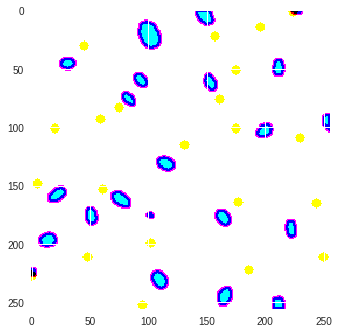

In [204]:
plt.imshow(target)

In [191]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'pytorch-multioutput-unet-10-epochs-version-2'})
uploaded.SetContentFile('model-10.pt')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1mAFw5YHozfpUBY6NYEREl1jvkHsLTkn1


In [0]:
!kill -9 -1